In [111]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import math



%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('../data/data2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112 entries, 0 to 2111
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         2112 non-null   int64  
 1   Substrate  2112 non-null   object 
 2   Ceramic    2112 non-null   object 
 3   Thickness  2112 non-null   float64
 4   Lsub       2112 non-null   float64
 5   asub       2112 non-null   float64
 6   bsub       2112 non-null   float64
 7   Lcer       2112 non-null   float64
 8   acer       2112 non-null   float64
 9   bcer       2112 non-null   float64
 10  L          2112 non-null   float64
 11  a          2112 non-null   float64
 12  b          2112 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 214.6+ KB


In [112]:
np.set_printoptions(suppress=True)

In [113]:
# Separate Target Variable and Predictor Variables
TargetVariable=['L', 'a', 'b']
Predictors=['Thickness','Lsub', 'asub','bsub', 'Lcer', 'acer', 'bcer']
 
X=df[Predictors].values
y=df[TargetVariable].values
 
### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)
 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1478, 7)
(1478, 3)
(634, 7)
(634, 3)


In [114]:
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense
 
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=2, input_dim=7, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
 
# There are 3 output neurons since we will be predicting a single number
model.add(Dense(3, kernel_initializer='normal', activation='linear'))
 
# Compiling the model
model.compile(loss='mae', optimizer='adam')
 
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 20, epochs = 50, verbose=0)

In [5]:
print(f'model score on training data: {model.evaluate(X_train, y_train, verbose = 0)}')
print(f'model score on testing data: {model.evaluate(X_test, y_test, verbose = 0)}')

model score on training data: 0.37907159328460693
model score on testing data: 0.3629368245601654


In [6]:
def FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes):
    layers = []
    
    nodes_increment = (last_layer_nodes - first_layer_nodes)/ (n_layers-1)
    nodes = first_layer_nodes
    for i in range(1, n_layers+1):
        layers.append(math.ceil(nodes))
        nodes = nodes + nodes_increment
    
    return layers

In [7]:
def createmodel(n_layers, first_layer_nodes, last_layer_nodes, activation_func, loss_func):
    model = Sequential()
    n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    for i in range(1, n_layers):
        if i==1:
            model.add(Dense(first_layer_nodes, input_dim=X_train.shape[1], activation=activation_func))
        else:
            model.add(Dense(n_nodes[i-1], activation=activation_func))
            
    #Finally, the output layer should have a single node in binary classification
    model.add(Dense(3, activation='linear'))
    model.compile(optimizer='adam', loss=loss_func, metrics = ["accuracy"]) #note: metrics could also be 'mse'
    
    return model

##Wrap model into scikit-learn
model =  KerasRegressor(build_fn=createmodel, verbose = False)  

In [11]:
activation_funcs = ['sigmoid']#, 'relu', 'tanh'] 
loss_funcs = ['mae'] #['mean_squared_error','hinge','mae']
param_grid = dict(n_layers=[1,2,3,4,5], first_layer_nodes = [7,6,5,4,3], last_layer_nodes = [7,6,5,4,3],  activation_func = activation_funcs, loss_func = loss_funcs, batch_size = [10, 20, 25, 50, 75, 100], epochs = [10, 20, 25, 50, 75, 100])
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv=10, n_jobs=3, verbose=1, scoring = "neg_mean_absolute_error")

In [12]:
%%time
grid.fit(X_train,y_train)

Fitting 10 folds for each of 4500 candidates, totalling 45000 fits


2022-09-14 23:48:22.518992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 23:48:22.518992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 23:48:22.518993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 00:04:54.353975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 00:04:56.557878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 00:04:57.661926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 00:22:33.823177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 00:22:37.012719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 00:22:37.149308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 00:43:09.170198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 00:43:12.434205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 00:43:26.814751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 01:04:30.566987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 01:04:34.688243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 01:04:34.916516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 01:25:52.252874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 01:25:54.565223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 01:25:55.488759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 01:47:14.339604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 01:47:17.597614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 01:47:19.123850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 02:08:38.783877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 02:08:39.087511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 02:08:42.066613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 02:26:06.197278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 02:26:09.469633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 02:26:23.720024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 02:42:46.046165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 02:42:49.337121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 02:43:17.030315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 03:02:05.203342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 03:02:08.444242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 03:02:45.448554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 03:22:46.429283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 03:22:49.640200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 03:23:04.030567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 03:43:39.358485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 03:43:42.573451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 03:44:10.479400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 03:59:03.910775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 03:59:07.213676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 03:59:12.772055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 04:17:11.086764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 04:17:13.936113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 04:17:14.395142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 04:36:55.054720: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 04:36:58.253319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 04:37:14.411462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 04:57:15.214640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 04:57:18.360892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 04:57:23.232060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 04:57:54.459962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 04:57:57.592424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:00:40.105967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 05:04:07.369387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:04:10.575937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:04:14.755797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 05:08:04.531294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:08:22.628236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:08:25.911878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 05:12:25.138965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:15:59.531743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:16:02.877190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 05:20:37.266739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:20:39.293493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:20:40.482852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 05:25:18.945369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:25:20.208047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:25:23.431624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 05:34:28.330165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:34:31.558779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:34:37.403554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 05:39:14.669420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:39:15.657665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:39:30.947898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 05:42:56.351128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:42:59.520741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:45:07.776735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 05:48:27.866044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:48:30.970739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:49:35.848045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 05:53:16.345345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:53:19.591831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:53:19.821208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 05:57:17.160687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:57:17.790944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 05:59:53.049349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 06:03:45.201643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:03:48.442126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:05:31.165934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 06:10:00.184691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:10:02.889269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:10:03.476979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 06:14:28.423256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:14:31.650938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:16:37.926004: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 06:19:45.997244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:19:49.232686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:21:01.142683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 06:24:23.245287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:24:26.422211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:24:33.115534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 06:28:16.465374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:28:19.611333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:30:08.599465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 06:34:16.535259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:34:19.793012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:36:23.093552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 06:40:29.250862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:40:30.766215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:40:32.448014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-09-15 06:45:01.336202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 06:45:04.583616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 1min 14s, sys: 12.7 s, total: 1min 27s
Wall time: 6h 57min 21s


GridSearchCV(cv=10,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9a671145e0>,
             n_jobs=3,
             param_grid={'activation_func': ['sigmoid'],
                         'batch_size': [10, 20, 25, 50, 75, 100],
                         'epochs': [10, 20, 25, 50, 75, 100],
                         'first_layer_nodes': [7, 6, 5, 4, 3],
                         'last_layer_nodes': [7, 6, 5, 4, 3],
                         'loss_func': ['mae'], 'n_layers': [1, 2, 3, 4, 5]},
             scoring='neg_mean_absolute_error', verbose=1)

In [13]:
print(grid.best_score_)
print(grid.best_params_)

-0.1341507347654126
{'activation_func': 'sigmoid', 'batch_size': 10, 'epochs': 100, 'first_layer_nodes': 7, 'last_layer_nodes': 7, 'loss_func': 'mae', 'n_layers': 3}


In [14]:
score_df = pd.DataFrame(grid.cv_results_)
score_df.sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation_func,param_batch_size,param_epochs,param_first_layer_nodes,param_last_layer_nodes,param_loss_func,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
627,8.691296,0.246523,0.070016,0.001014,sigmoid,10,100,7,7,mae,...,-0.138533,-0.120980,-0.135308,-0.143027,-0.127375,-0.145140,-0.113437,-0.134151,0.018095,1
646,8.257902,0.261686,0.065291,0.001024,sigmoid,10,100,7,3,mae,...,-0.188005,-0.123128,-0.154223,-0.102823,-0.111495,-0.205542,-0.124449,-0.140606,0.031612,2
637,8.821389,0.249894,0.071027,0.000722,sigmoid,10,100,7,5,mae,...,-0.155804,-0.173948,-0.138290,-0.100193,-0.144471,-0.171214,-0.122564,-0.141429,0.021620,3
632,8.884637,0.221431,0.072396,0.002714,sigmoid,10,100,7,6,mae,...,-0.170630,-0.109471,-0.154494,-0.109876,-0.135598,-0.154493,-0.185251,-0.142284,0.024986,4
647,8.690369,0.202428,0.070755,0.000797,sigmoid,10,100,7,3,mae,...,-0.134749,-0.152861,-0.157477,-0.126596,-0.147347,-0.130908,-0.161134,-0.143258,0.012339,5


In [115]:
# Running the best parameters for the NN

# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=7, input_dim=7, activation='sigmoid'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=7, activation='sigmoid'))
model.add(Dense(units=7, activation='sigmoid'))
 
# There are 3 output neurons since we will be predicting a single number
model.add(Dense(3, activation='linear'))
 
# Compiling the model
model.compile(loss='mae', optimizer='adam')
 
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 10, epochs = 100, verbose=0)

In [116]:
# Generating Predictions on testing data
Predictions=model.predict(X_test)
 
# Scaling the predicted Price data back to original price scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)
 
# Scaling the y_test Price data back to original price scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)
 
# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
y_orig = pd.DataFrame(data=y_test_orig, columns=TargetVariable)
y_pred = pd.DataFrame(data=Predictions, columns=TargetVariable)

20/20 [==============================] - 0s 821us/step


In [117]:
# Computing the absolute percent error
MAE=abs(y_orig['L']-y_pred['L'])
print('The Accuracy of L using the ANN model is:', np.mean(MAE),"(std=",np.std(MAE),")")

# Computing the absolute percent error
MAE=abs(y_orig['a']-y_pred['a'])
print('The Accuracy of a using the ANN model is:', np.mean(MAE),"(std=",np.std(MAE),")")

# Computing the absolute percent error
MAE=abs(y_orig['b']-y_pred['b'])
print('The Accuracy of b using the ANN model is:', np.mean(MAE),"(std=",np.std(MAE),")")


The Accuracy of L using the ANN model is: 1.3713824417162397 (std= 2.3260687258991273 )
The Accuracy of a using the ANN model is: 0.22550683827500792 (std= 0.2648662808153097 )
The Accuracy of b using the ANN model is: 0.9104069969575113 (std= 1.0358720540946853 )


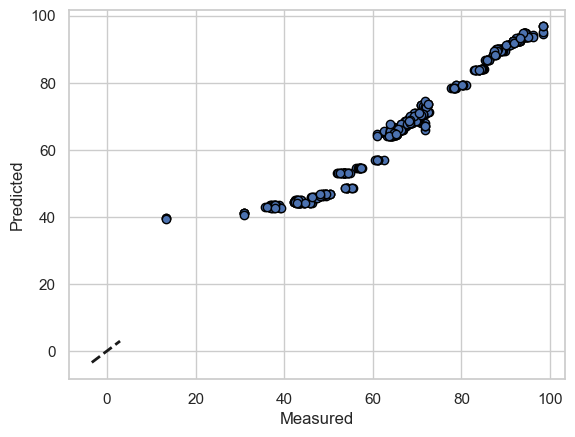

In [118]:
fig, ax = plt.subplots()
ax.scatter(y_orig['L'], y_pred['L'], edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=2)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

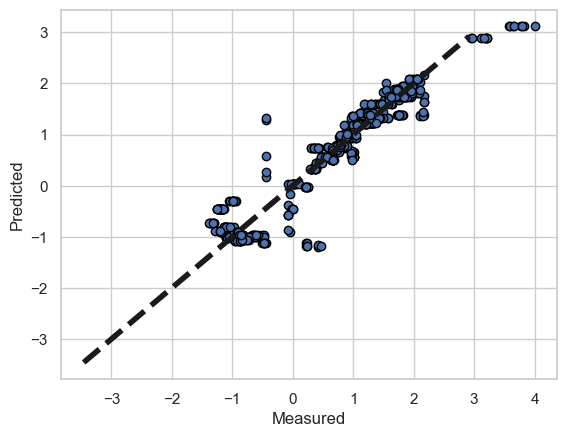

In [119]:
fig, ax = plt.subplots()
ax.scatter(y_orig['a'], y_pred['a'], edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

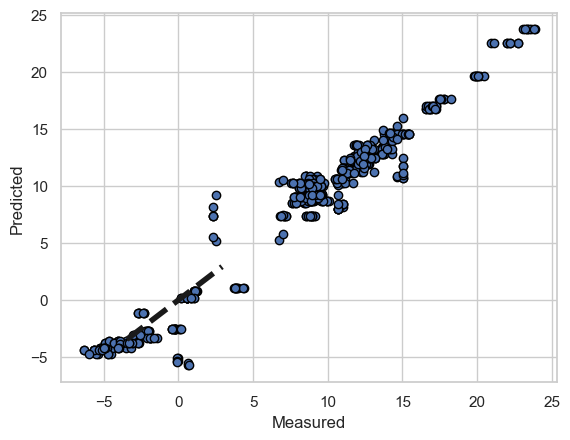

In [120]:
fig, ax = plt.subplots()
ax.scatter(y_orig['b'], y_pred['b'], edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

In [97]:
# Define regression model in Keras
def regression_model():
    # Define model
    model = Sequential()
    model.add(Dense(units=7, input_dim=7, activation='sigmoid'))
    model.add(Dense(units=7, activation='sigmoid'))
    model.add(Dense(units=7, activation='sigmoid'))
    model.add(Dense(3, activation='linear'))
    model.compile(loss='mae', optimizer='adam')

    
    return model

# Use KerasRegressor wrapper (from Keras to sklearn)
# The packages we use are meant to be run with sklearn models
estimator = KerasRegressor(build_fn=regression_model, validation_split = 0.2, epochs=100, batch_size = 10, verbose=0)
history = estimator.fit(X_train, y_train)

dict_keys(['loss', 'val_loss'])


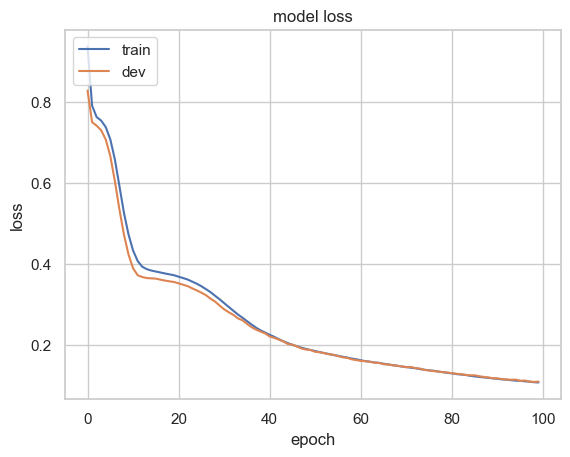

In [98]:
# summarize history loss
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [99]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator, random_state=1).fit(X_train,y_train)
eli5.show_weights(perm, feature_names = Predictors)

Weight,Feature
0.8075 ± 0.0306,Lsub
0.3543 ± 0.0110,bsub
0.1669 ± 0.0036,Thickness
0.0994 ± 0.0069,acer
0.0471 ± 0.0030,Lcer
0.0413 ± 0.0047,asub
0.0320 ± 0.0029,bcer


In [101]:
#get model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(units=7, input_dim=7, activation='sigmoid'))
    model.add(Dense(units=7, activation='sigmoid'))
    model.add(Dense(units=7, activation='sigmoid'))
    model.add(Dense(3, activation='linear'))
    model.compile(loss='mae', optimizer='adam')
    return model

In [102]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = []
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100, batch_size = 20)
        # evaluate model on test set
        mae = model.evaluate(X_test, y_test, verbose=0)
        # store result
        print('>%.3f' % mae)
        results.append(mae)
    return results

In [103]:
# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

>0.127
>0.134
>0.122
>0.102
>0.098
>0.090
>0.133
>0.088
>0.082
>0.131
>0.099
>0.111
>0.096
>0.111
>0.122
>0.094
>0.094
>0.082
>0.107
>0.094
>0.112
>0.106
>0.132
>0.133
>0.087
>0.090
>0.089
>0.109
>0.117
>0.092
MAE: 0.106 (0.016)


In [121]:
scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

pred = pd.DataFrame(model.predict(X_test_scaled), columns=['Lpred','apred','bpred'])

20/20 [==============================] - 0s 706us/step


In [127]:
import gradio as gr

def greet(Thickness, Lsub, asub, bsub, Lcer, acer, bcer):
    list = [Thickness, Lsub, asub, bsub, Lcer, acer, bcer]
    df2 = pd.DataFrame(list).T
    df2 = PredictorScalerFit.transform(df2)
    output = model.predict(df2)
    output = TargetVarScalerFit.inverse_transform(output)

    Lf = pd.DataFrame(output, columns = ['L', 'a', 'b'])._get_value(0, 'L')
    af = pd.DataFrame(output, columns = ['L', 'a', 'b'])._get_value(0, 'a')
    bf = pd.DataFrame(output, columns = ['L', 'a', 'b'])._get_value(0, 'b')
    
    Lf = np.clip(Lf, np.min([Lcer,Lsub]), np.max([Lcer,Lsub]))
    af = np.clip(af, np.min([acer,asub]), np.max([acer,asub]))
    bf = np.clip(bf, np.min([bcer,bsub]), np.max([bcer,bsub]))
    
    return Lf, af, bf

demo = gr.Interface(fn=greet, inputs=[gr.Slider(0.3, 1.5, 0.1),
                                      gr.Slider(50, 100, 1),
                                      gr.Slider(-2, 4, 0.2),
                                      gr.Slider(-5, 25, 0.5),
                                      gr.Slider(50, 100, 1),
                                      gr.Slider(-2, 4, 0.2),
                                      gr.Slider(-5, 25, 0.2)], outputs=["number","number", "number"])

In [128]:
demo.launch()

Running on local URL:  http://127.0.0.1:7874

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7f9a59d5d340>, 'http://127.0.0.1:7874/', None)

1/1 [==============================] - 0s 16ms/step
